# Анализ повести Ф.М.Достоевского «**Двойник**» с помощью модели LDA

## Подключение библиотек и загрузка произведения в код программы 

In [2]:
import re
import spacy
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
from collections import Counter
import matplotlib.pyplot as plt

# Считываем файл с произведением
with open("the_double.txt", mode="r", encoding='windows-1251') as f:
    data = f.read()

## Предобработка текста 

#### Токенизация по главам

In [4]:
# Делим текст произведения по римским цифрам на главы, заглавление и эпиграф
data = re.split(r"[IVXLCDM]", data)
# Чистим список от пустых строк (необходимо для корректного отображения глав из-за особенности функции re.split())
docs = [] 
for el in data:
  if el != "":
    docs.append(el)
print("Число глав в произведении: ", len(docs))

Число глав в произведении:  15


In [5]:
# Очистка пунктуации от лишних символов
def clean_text(text):
  pattern = r'[^а-яА-ЯёЁйЙ\s]'
  blanks_newline = r"\s+"
  cleaned_text = re.sub(pattern, '', text)
  cleaned_text = re.sub(blanks_newline, ' ', cleaned_text)
  cleaned_text = cleaned_text.lower()
  return cleaned_text

for i in range(len(docs)):
  docs[i] = clean_text(docs[i].strip())

#### Токенизация по словам внутри документа и лемматизация + удаление стоп-слов 

In [6]:
# Считываем стоп-слова из файла и сохраняем в список stopwords_list
with open("stopwords.txt", 'r', encoding='utf-8') as file:
  line = file.readline().strip()

  stopwords_list = []
  for word in line.split(','):
    stopwords_list.append(word.strip())

# Вызываем и сохраняем в переменную nlp модель spacy для обработки русского языка
nlp = spacy.load("ru_core_news_md")

# Функция lemmatize делит на леммы строку text, с помощью модели из spacy (nlp) и сохраняет полученные леммы в список data_lemma
def lemmatize(text, stopwords_list):
  doc = nlp(text)
  data_lemma = []
  for token in doc:
    if token.is_stop == False and token.pos_ != "PUNCT" and token.lemma_ not in stopwords_list:
      data_lemma.append(token.lemma_)
  return data_lemma

# Лемматизируем каждый элемент из списка docs, т.е. каждую ранее выделенную главу исходного текста, и сохраняем их в список docs_lemma 
docs_lemma = []
for doc in docs:
  docs_lemma.append(lemmatize(doc, stopwords_list))

## LDA модель

In [18]:
# Передаем список лемм для каждого документа (главы) в lda-модель
id2word = corpora.Dictionary(docs_lemma) # Словарь id + слово
# Убираем из словаря слова, которые встречаются менее чем в 2 документах и в более чем 70% документов
id2word.filter_extremes(no_below=2, no_above=0.7) 
corpus = []
# Таблица (матрица), где сопоставлены слова и документы, в которых они встречаются - терм-документная матрица
for text in docs_lemma:
  corpus.append(id2word.doc2bow(text)) 

# Сама LDA модель
lda_model = LdaModel(
  corpus=corpus, # Терм-документная матрица
  id2word=id2word, # id + слово
  num_topics=4, # Количество тем
  random_state=42, # LDA - вероятностная модель, этот параметр не даст меняться результатам при каждом запуске
  chunksize=10, # Размер кусочка (количество документов) для тренинировочной итерации
  passes=200, # Сколько раз модель проходит через корпус (влияет на длительность и качество работы!)
  alpha='auto' # Подстраиваемся под наш конкретный случай распределения документов
  ) 

## Результаты и оценка интерпретируемости тем

#### Вывод тем

In [23]:
# Способ 1
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.016*"антон" + 0.016*"антонович" + 0.015*"петрович" + 0.015*"яков" + 0.008*"голядкинмладший"')
(1, '0.012*"гость" + 0.011*"крестьянин" + 0.008*"крестьян" + 0.006*"понимать" + 0.006*"письмо"')
(2, '0.006*"сударыня" + 0.006*"круг" + 0.005*"советник" + 0.005*"петрович" + 0.005*"яков"')
(3, '0.025*"милый" + 0.018*"превосходительство" + 0.017*"сударь" + 0.012*"карета" + 0.008*"принимать"')


In [24]:
# Способ 2
lda_model.show_topics()

[(0,
  '0.016*"антон" + 0.016*"антонович" + 0.015*"петрович" + 0.015*"яков" + 0.008*"голядкинмладший" + 0.007*"превосходительство" + 0.006*"голядкинастаршего" + 0.005*"известный" + 0.005*"чиновник" + 0.004*"милый"'),
 (1,
  '0.012*"гость" + 0.011*"крестьянин" + 0.008*"крестьян" + 0.006*"понимать" + 0.006*"письмо" + 0.006*"государь" + 0.006*"милостивый" + 0.005*"барин" + 0.004*"этакой" + 0.004*"жить"'),
 (2,
  '0.006*"сударыня" + 0.006*"круг" + 0.005*"советник" + 0.005*"петрович" + 0.005*"яков" + 0.005*"олсуфия" + 0.004*"окно" + 0.004*"прямо" + 0.004*"карета" + 0.004*"клара"'),
 (3,
  '0.025*"милый" + 0.018*"превосходительство" + 0.017*"сударь" + 0.012*"карета" + 0.008*"принимать" + 0.008*"известный" + 0.007*"бог" + 0.007*"сударыня" + 0.005*"объясниться" + 0.005*"известнос"')]

#### Топики для каждой главы (документа)

In [10]:
# В качестве примера выбрана глава 4 (нумерация с 0)
docs[3]

'все это утро прошло в страшных хлопотах у господина голядкина попав на невский проспект герой наш приказал остановиться у гостиного двора выпрыгнув из своего экипажа побежал он под аркаду в сопровождении петрушки и пошел прямо в лавку серебряных и золотых изделий заметно было уже по одному виду господина голядкина что у него хлопот полон рот и дела страшная куча сторговав полный обеденный и чайный сервиз с лишком на тысячу пятьсот рублей ассигнациями и выторговав себе в эту сумму затейливой формы сигарочницу и полный серебряный прибор для бритья бороды приценившись наконец еще к коекаким в своем роде полезным и приятным вещицам господин голядкин кончил тем что обещал завтра же зайти непременно или даже сегодня прислать за сторгованным взял нумер лавки и выслушав внимательно купца хлопотавшего о задаточке обещал в свое время и задаточек после чего он поспешно распростился с недоумевающим купцом и пошел вдоль по линии преследуемый целой стаей сидельцев поминутно оглядываясь назад на пет

In [11]:
# Получим распределение тем для конкретной главы, например, четвертой
lda_model.get_document_topics(corpus)[3]
# Вывод в формате [(id темы, вероятность), (id темы, вероятность), ...], если нужна вероятность в процентах, мысленно умножьте вероятность на 100

[(0, 0.3149275), (2, 0.5663327), (3, 0.11868469)]

#### Формальная оценка результатов

In [12]:
# Создаем переменную для метрики c_v, которая основана на статистике взаимной информации между словами в темах
coherence_model_lda_cv = CoherenceModel(model=lda_model, texts=docs_lemma, dictionary=id2word, coherence='c_v')
# Вычисление когерентности для метрики c_v
coherence_lda_cv = coherence_model_lda_cv.get_coherence()
# Создание переменную для метрики u_mass,которая основана на логарифмической вероятности совместного появления слов в темах
coherence_model_lda_umass = CoherenceModel(model=lda_model, texts=docs_lemma, dictionary=id2word, coherence='u_mass')
# Вычисление когерентности для метрики u_mass
coherence_lda_umass = coherence_model_lda_umass.get_coherence()
# Вывод результатов
print("\nCoherence Score (UMass): ", coherence_lda_umass)
print("\nCoherence Score (C_V): ", coherence_lda_cv)


Coherence Score (UMass):  -0.893519469853478

Coherence Score (C_V):  0.2982050925819967


## Визуальное представление результатов

In [13]:
pyLDAvis.enable_notebook()
# Переменная для подготовленных данных для визуализации модели LDA и сама подготовка
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="pcoa", R=15)
# Отображение визуализации 
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.026406 -0.141901       1        1  34.112446
2     -0.035456  0.073300       2        1  29.438865
1     -0.085057  0.048397       3        1  28.237274
3      0.146920  0.020204       4        1   8.211415, topic_info=                    Term       Freq      Total Category  logprob  loglift
888                милый  61.000000  61.000000  Default  15.0000  15.0000
683   превосходительство  55.000000  55.000000  Default  14.0000  14.0000
1046               антон  76.000000  76.000000  Default  13.0000  13.0000
1047           антонович  74.000000  74.000000  Default  12.0000  12.0000
381               сударь  32.000000  32.000000  Default  11.0000  11.0000
...                  ...        ...        ...      ...      ...      ...
1312            сударыня   7.348355  33.289297   Topic4  -5.0244   0.9889
867         измайловский   4.853504  12.664510   Topic4  -5.4391   1.5405
900              нельзяс   3.855564   7.177408   Topic4  -5.6693   1.8782
892                 мост   4.657865  17.951351   Topic4  -5.4803   1.1505
81                добрый   5.057816  30.099511   Topic4  -5.3979   0.7161

[146 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1046      1  0.988163       антон
1046      2  0.013002       антон
1047      1  0.977387   антонович
1047      2  0.013389   антонович
2         4  0.739228  ассигнация
...     ...       ...         ...
1380      4  0.107380      этакой
1045      2  0.932685       юноша
439       1  0.660353        яков
439       2  0.194221        яков
439       3  0.135955        яков

[254 rows x 3 columns], R=15, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

## Частеречный анализ

### Лемматизация

In [14]:
# Аналогично функции lemmatize, делаем леммы без учета стоп-слов
def lemmatize_pos(text, nlp):
  doc = nlp(text)
  data_lemma2 = {}
  for token in doc:
    if token.is_stop == False and token.pos_ != "PUNCT":
      data_lemma2[token.lemma_] = token.pos_
  return data_lemma2

# Объединяем все главы в одну строку
full_text = " ".join(docs)
# Очищаем текст
cleaned_text = clean_text(full_text)
# Лемматизируем и получаем части речи
dost = lemmatize_pos(cleaned_text, nlp)

#### Визуализация в виде круговых диаграмм

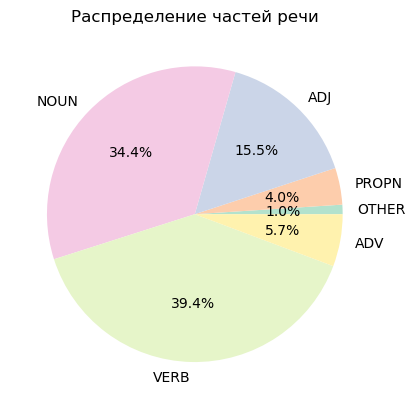

In [15]:
# Подготовка данных к визуализации
pos_counts = Counter(dost.values())
pos_counts = dict(pos_counts)

# В summ_dost будут храниться только те части речи, которые встречаются часто (частота >= 150)
# А все редкие части речи будут объединены в категорию "OTHER"
summ_dost = {"OTHER":0}
for key, value in pos_counts.items():
  if value < 150:
    summ_dost["OTHER"] += value
  else:
    summ_dost[key] = value

# Список меток для диаграммы
pos = list(summ_dost.keys())
# Список значений для диаграммы
amount = list(summ_dost.values())

# Построение круговых диаграм
plt.pie(
    amount,
    labels=pos,
    autopct='%1.1f%%',
    colors=plt.cm.Pastel2.colors
)
plt.title('Распределение частей речи')
plt.show()